In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn import discriminant_analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, roc_auc_score

In [2]:
class ClassificationModels:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)

    def histograma(self, probabilidades, modelo):
        juntar = pd.DataFrame({
        'real': self.y_test,
        'probabilidades': probabilidades
        })
        plt.figure(figsize=(10, 5))
        plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
        plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
        plt.title(f'Histograma de probabilidades de {modelo}')
        plt.legend()
        plt.show()
        print()
    
    def calibracion(self, probabilidades, modelo, bins = 10):
        calibracion = pd.DataFrame({
        'target': self.y_test, 
        'probabilidades': probabilidades
        })

        calibracion['bins'] = pd.qcut(calibracion['probabilidades'], q=bins, labels=False) + 1
        grouped = calibracion.groupby('bins').mean()
        
        plt.figure(figsize=(10, 5))
        plt.plot(grouped.probabilidades, grouped.target, marker="o", c = 'skyblue')
        plt.plot(grouped.probabilidades, grouped.probabilidades, marker='o', c="indianred")
        plt.xlabel("Probabilidad")
        plt.ylabel("Real")
        plt.title(f'Gráfica de calibración de {modelo}')
        plt.grid()
        plt.show()

    def roc_curve(self, probabilidades, modelo):
        fpr, fnp, _ = roc_curve(y_score=probabilidades, y_true=self.y_test)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, fnp, c='skyblue')
        plt.plot([0, 1], [0, 1], c='indianred')
        plt.title(f'Curva ROC de {modelo}')
        plt.show()


    def logistic_regression(self):
        model = linear_model.LogisticRegression().fit(self.X_train, self.y_train)
        probabilidades = model.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)


        coeficientes = pd.DataFrame({
            'features': self.X.columns,
            'coeficiente': model.coef_[0]
        })
        display(coeficientes)
        self.calibracion(probabilidades, modelo='regresión logística')
        self.roc_curve(probabilidades, modelo='regresión logística')
        self.histograma(probabilidades, modelo='regresión logística')
        return auc
    
    def logistic_regression_poly(self, degree=2):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=degree)),
            ('logistic', linear_model.LogisticRegression(penalty='l2'))
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.calibracion(probabilidades, modelo=f'regresión logística grado {degree}')
        self.roc_curve(probabilidades, modelo=f'regresión logística grado {degree}')
        self.histograma(probabilidades, modelo=f'regresión logística grado {degree}')
        return auc  

    def discriminant_analysis(self):
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.calibracion(probabilidades, modelo='discriminante lineal')
        self.roc_curve(probabilidades, modelo='discriminante lineal')
        self.histograma(probabilidades, modelo='discriminante lineal')
        return auc
    
    def knn_classification(self):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)

        auc = [roc_auc_score(y_score=neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled,self.y_train).predict_proba(X_test_scaled)[:, 1], y_true=self.y_test) for i in range(1,100)]

        knn = pd.DataFrame({
            'nn': range(1,100),
            'auc':auc
        })

        opt_nn = knn[knn['auc']==knn['auc'].max()]['nn'].values[0]
        model = neighbors.KNeighborsClassifier(n_neighbors=opt_nn).fit(X_train_scaled, self.y_train)
        probabilidades = model.predict_proba(X_test_scaled)[:, 1]
        auc = auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)
        
        self.calibracion(probabilidades, modelo=f'knn con {opt_nn} vecinos')
        self.roc_curve(probabilidades, modelo=f'knn con {opt_nn} vecinos')
        self.histograma(probabilidades, modelo=f'knn con {opt_nn} vecinos')
        return knn[knn['auc']==knn['auc'].max()]
    
    def run_models(self):
        modelos = [
            'logistic_regression',
            'logistic_regression_poly2',
            'logistic_regression_poly3',
            'knn',
            'discriminant_analysis'
        ]
        aucs = [
            self.logistic_regression(),
            self.logistic_regression_poly(degree=2),
            self.logistic_regression_poly(degree=3),
            self.knn_classification()['auc'].values[0],
            self.discriminant_analysis()
        ]
        aucs = np.array(aucs)
        resultados = pd.DataFrame({
            'modelos': modelos,
            'auc': aucs,
            'gini': (2 * aucs) -1
        })
        return resultados

In [3]:
df = pd.read_csv('alzheimers_disease_data.csv')
df = df.drop(columns=['DoctorInCharge','PatientID'])
df = pd.get_dummies(df, columns=['Ethnicity','EducationLevel'])
df.head()

,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,Forgetfulness,Diagnosis,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,EducationLevel_0,EducationLevel_1,EducationLevel_2,EducationLevel_3
0,73,0,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,...,0,0,True,False,False,False,False,False,True,False
1,89,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,...,1,0,True,False,False,False,True,False,False,False
2,73,0,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,...,0,0,False,False,False,True,False,True,False,False
3,74,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,...,0,0,True,False,False,False,False,True,False,False
4,89,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,...,0,0,True,False,False,False,True,False,False,False


In [4]:
target = 'Diagnosis'
X = df.copy()
X = X.drop(columns=target)
y = df[target]

models = ClassificationModels(X, y)

,features,coeficiente
0,Age,0.017198
1,Gender,0.134709
2,BMI,-0.018805
3,Smoking,-0.017405
4,AlcoholConsumption,-0.041112
5,PhysicalActivity,-0.029838
6,DietQuality,0.068912
7,SleepQuality,-0.095315
8,FamilyHistoryAlzheimers,-0.023929
9,CardiovascularDisease,0.066169


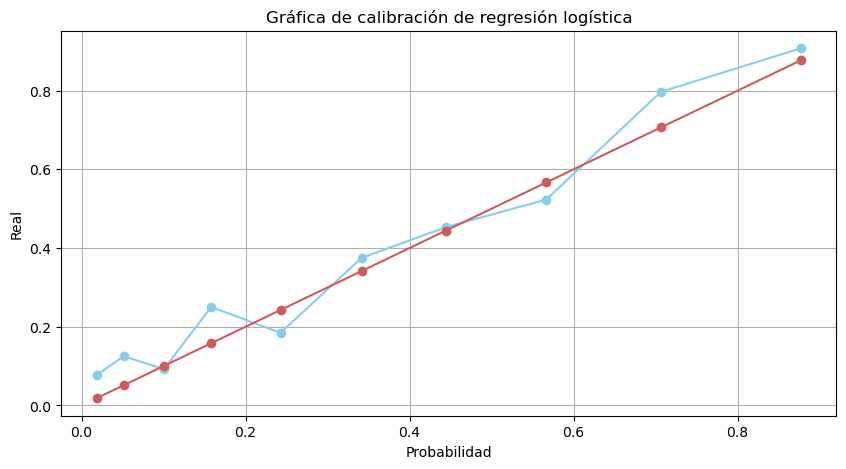

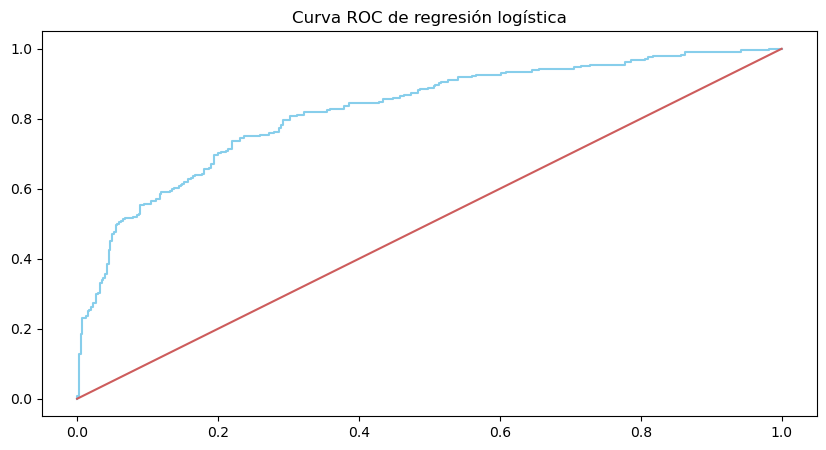

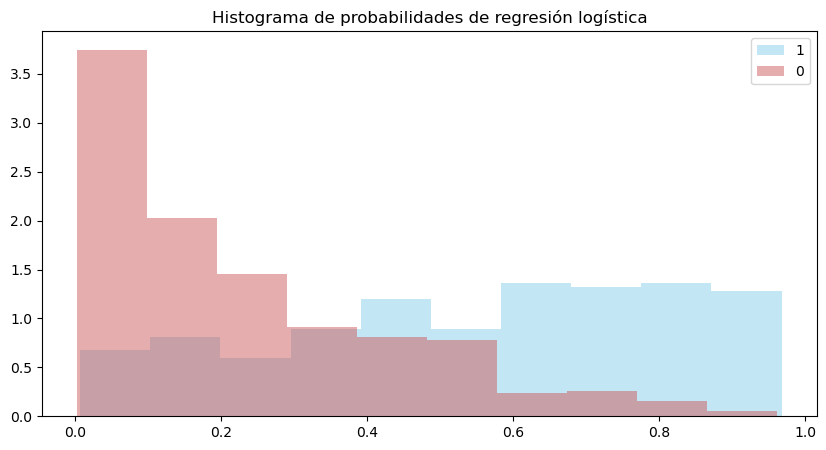

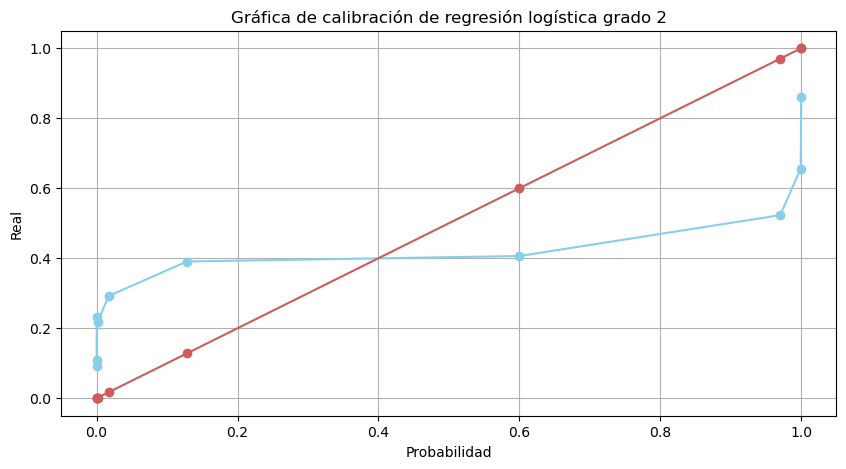

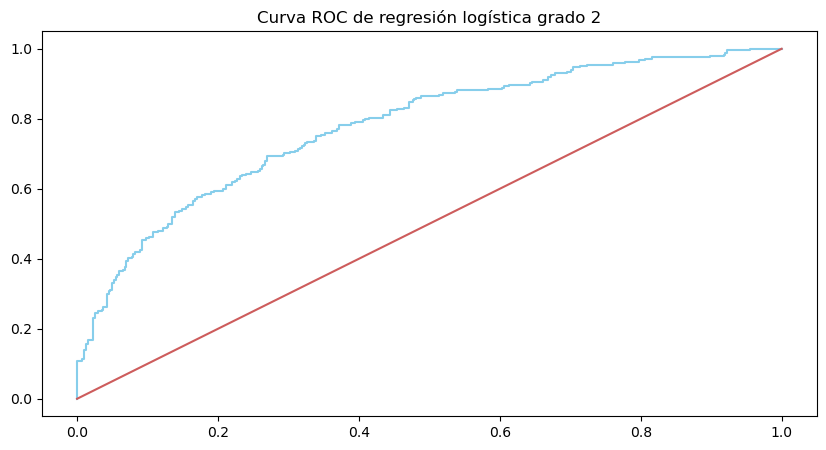

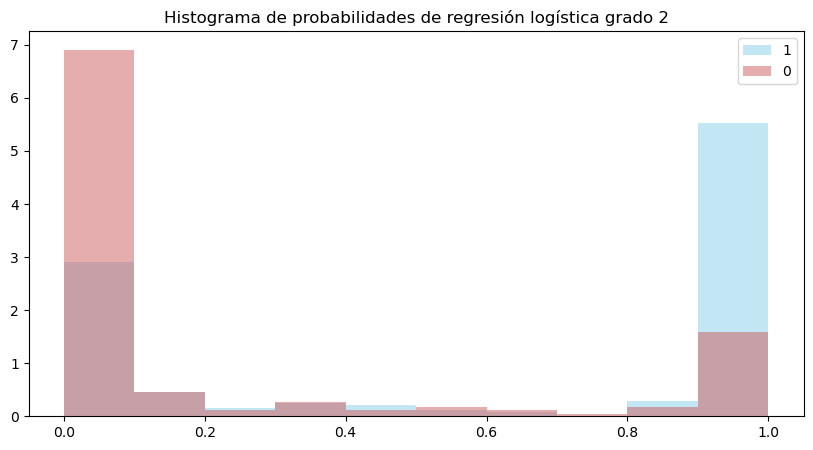

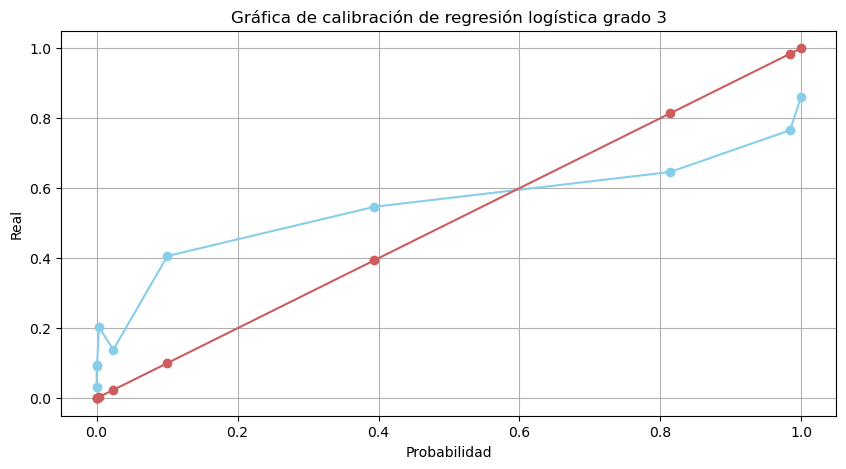

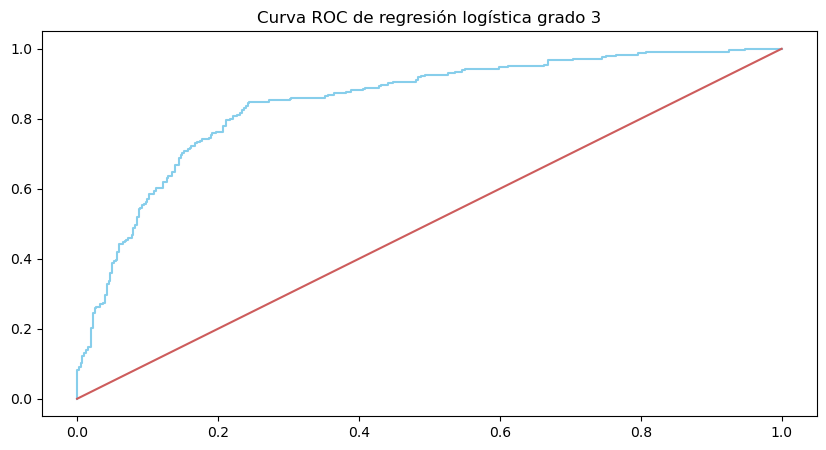

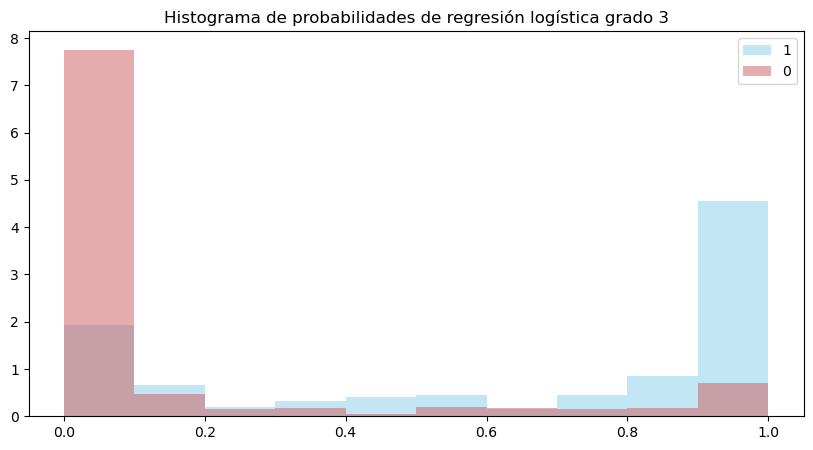

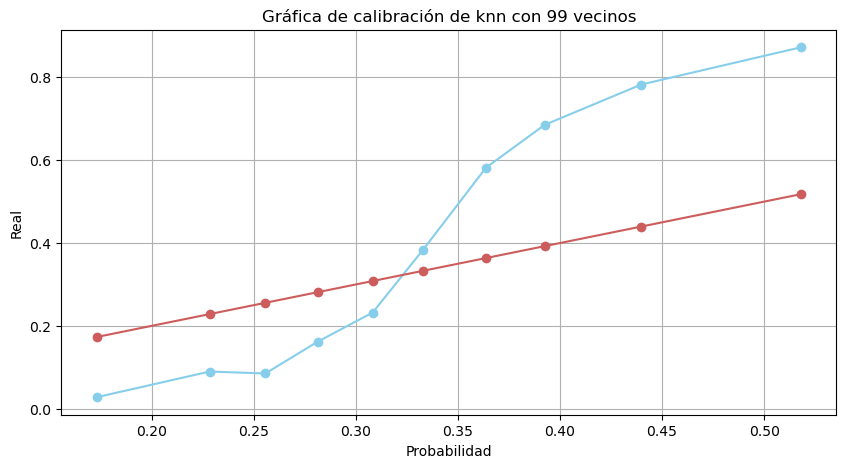

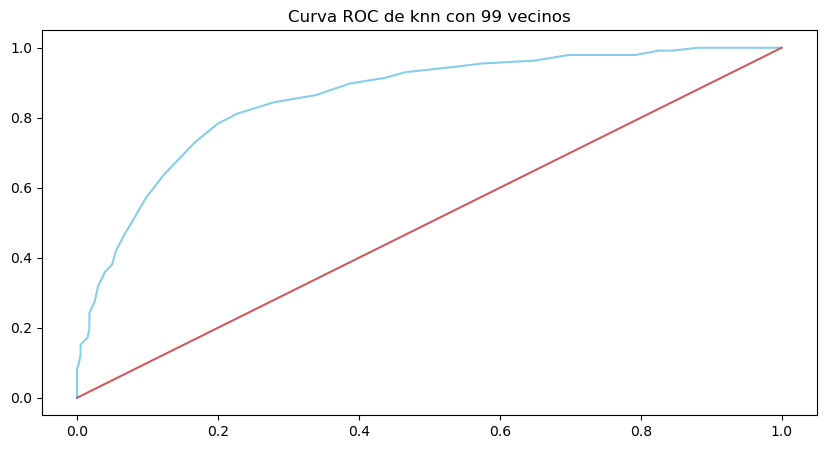

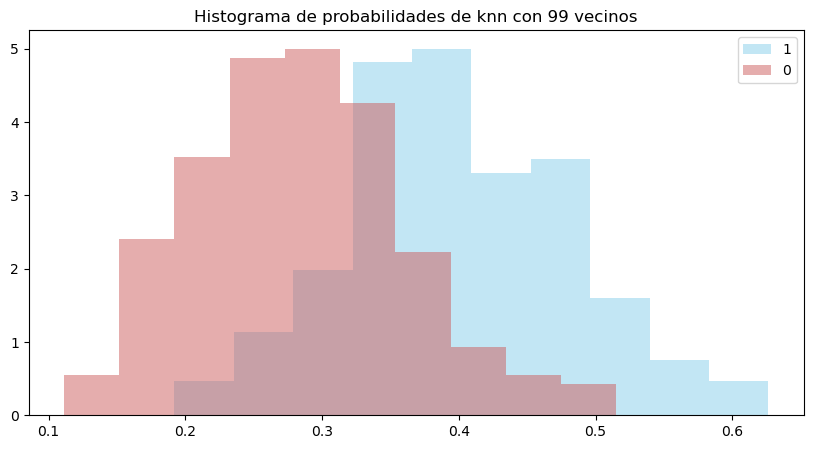

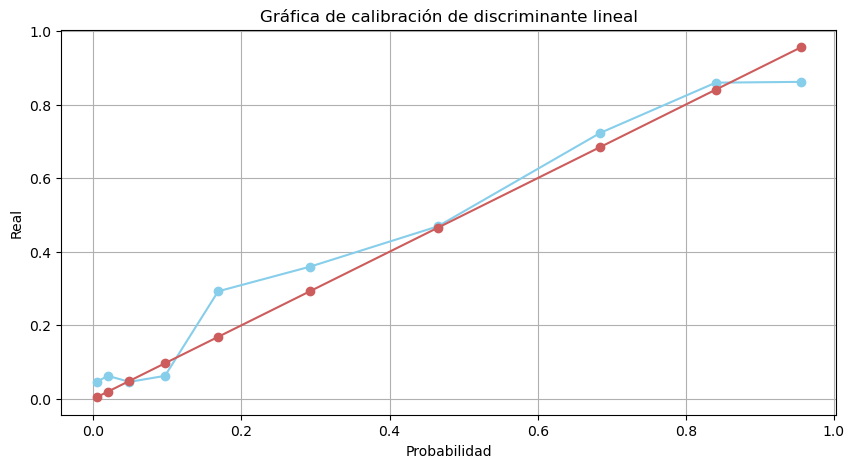

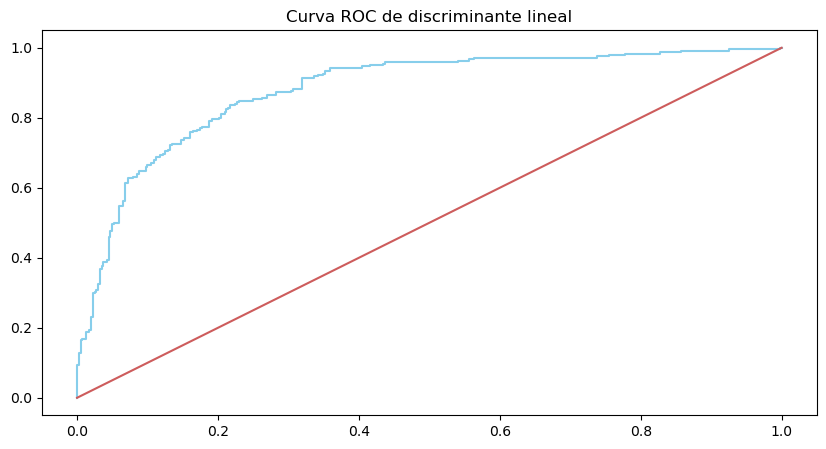

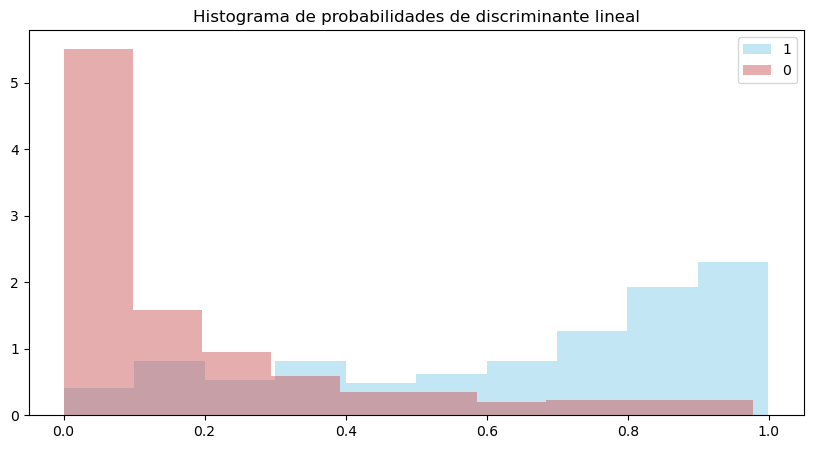

,modelos,auc,gini
0,logistic_regression,0.823270,0.646539
1,logistic_regression_poly2,0.777442,0.554883
2,logistic_regression_poly3,0.848034,0.696067
3,knn,0.857406,0.714811
4,discriminant_analysis,0.879533,0.759065


In [5]:
models.run_models()

## Análisis

Los coeficientes de la regresión logística represntan las log-odds, sin embargo, al momento de calcular las probabilidades se usan como un exponente de $e$, por lo que se mantiene su signo y significado. Es decir, si es positivo entonces contribuye a aumentar la probabilidad de que la predicción sea 1, es este caso, a que el paciente tenga alzheimer.

Viendo los coeficientes obtenidos vemos que los factores que más contributen a que una persona tenga alzheimer son:

- Quejas de memoria (0.914171).
- Problemas de conducta (0.609267).
- Género (0.134709).

Estos son los factores que más contributen a la posibilidad de tener alzheimer de acuerdo a nuestro modelo. Quejarse sobre tu memoria y no recordar cosas es bastante obvio qu sea un factor alto, pues de esto trata la enfermedad, y presentar mala memoria es un síntoma inicial de tener la enfermedad, así como problemas de conducta, pues podríamos cambiar nuestra conducta ante ciertas situaciones por no poder recordar con calridad, además que de que el género influye pero bastante menos.

El mejor modelo obtenido fue el discriminante lineal, que obtuvo un auc (area under the curve) de 0.8795, siendo el más alto de todos los modelos, lo que significa que tiene una alta proporción de verdaderos positivos y baja proporción de falsos positivos. Como tiene un auc de 0.8795, significa que es muy probable que clasifique correctamente a un paciente enfermo y pueda distinguir bien entre clases.


